In [ ]:
import torch
import torch.nn as nn
import os
import re 
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import LabelEncoder, label_binarize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



In [2]:

# hyper-params.
MAX_WORDS = 20000           # Maximum vocab size  
MAX_LEN = 80                # max tokens per samp le (tune)
EMBEDDING_DIM = 100         # matches chosen GloVe (100d)
HIDDEN_SIZE = 256
NUM_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.3
BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 8
NUM_CLASSES = 6
N_HEADS = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
df = pd.read_csv("yt_comments_data.csv")
df.columns = ['id','Text','Emotion']
df.drop('id', axis = 1, inplace = True)
df.head()


,Text,Emotion
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love


In [4]:
# Changing text to lowercase and removing punctuations and numbers
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'\d+','',text)
    return text

# Removing extra spaces
def rem_wspaces(text):
    return ' '.join(text.split())

# Removing HTML tags and URLs
def rem_tags_urls(text):
    text = re.sub(r"http?://\S+|www.\.\S+", "", text)
    text = re.sub(r"https?://\S+|www.\.\S+", "", text)
    return re.sub(r'<.*?>','',text)

# Tokenize the sentences
def tokenize(text):
    text = text.strip('.')
    return text.split()

# Removing stopwords such as a, an, the, are, etc.
def rem_stopwords(text):
    t_text = tokenize(text)
    f_text = [word for word in t_text if word not in stopwords]
    return f_text

In [5]:
texts = df['Text'].astype(str).apply(clean_text).tolist()
labels = df['Emotion'].tolist()

In [6]:
df['Emotion'].value_counts()

Emotion
joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: count, dtype: int64

<Axes: xlabel='Emotion', ylabel='count'>

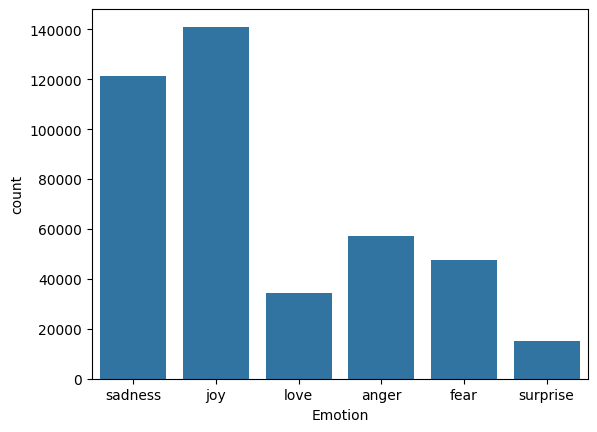

In [7]:
sns.countplot(x = 'Emotion', data = df)

In [8]:
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')


In [9]:
# Encoding emotion labels (joy, sadness, etc.) into integers.
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)


In [10]:
# Save tokenizer and label encoder for future inference
os.makedirs("models", exist_ok=True)

with open("models/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

with open("models/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("Saved tokenizer.pkl and label_encoder.pkl.")


Saved tokenizer.pkl and label_encoder.pkl.


In [11]:
X_train, X_test, y_train, y_test = train_test_split(padded, y_encoded, test_size=0.2, random_state=42)


In [12]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TextDataset(X_train, y_train)
test_ds = TextDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)


In [13]:
# model training
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out

In [14]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


model = LSTMClassifier(MAX_WORDS, EMBEDDING_DIM, HIDDEN_SIZE, NUM_CLASSES).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

CHECKPOINT_PATH = "checkpoints/lstm_checkpoint.pth"
os.makedirs("checkpoints", exist_ok=True)

start_epoch = 0

if os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resuming training from epoch {start_epoch}")


# Train
for epoch in range(start_epoch, EPOCHS):
    model.train()
    running_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {running_loss:.4f}")

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'config': {
            'max_words': MAX_WORDS,
            'max_len': MAX_LEN,
            'hidden_size': HIDDEN_SIZE,
            'num_classes': NUM_CLASSES
        }
    }, CHECKPOINT_PATH)

Using device: cpu
Resuming training from epoch 8


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# model = LSTMClassifier(MAX_WORDS, EMBEDDING_DIM, HIDDEN_SIZE, NUM_CLASSES).to(device)
# model.load_state_dict(torch.load("lstm_model_final.pth", map_location=device))
# model.eval()

Using device: cpu


LSTMClassifier(
  (embedding): Embedding(20000, 100)
  (lstm): LSTM(100, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)

Model Accuracy: 93.67%
F1 Score (weighted): 93.63%

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94     11339
           1       0.84      0.98      0.90      9376
           2       0.96      0.95      0.95     28247
           3       0.82      0.87      0.84      6853
           4       0.97      0.98      0.97     24504
           5       0.99      0.64      0.78      3043

    accuracy                           0.94     83362
   macro avg       0.93      0.89      0.90     83362
weighted avg       0.94      0.94      0.94     83362

Confusion Matrix:
 [[10176   514    53     6   589     1]
 [   51  9199    19     0   105     2]
 [   54    30 26771  1344    26    22]
 [    2     1   868  5982     0     0]
 [   73   401    34     0 23996     0]
 [    0   822   239     0    21  1961]]


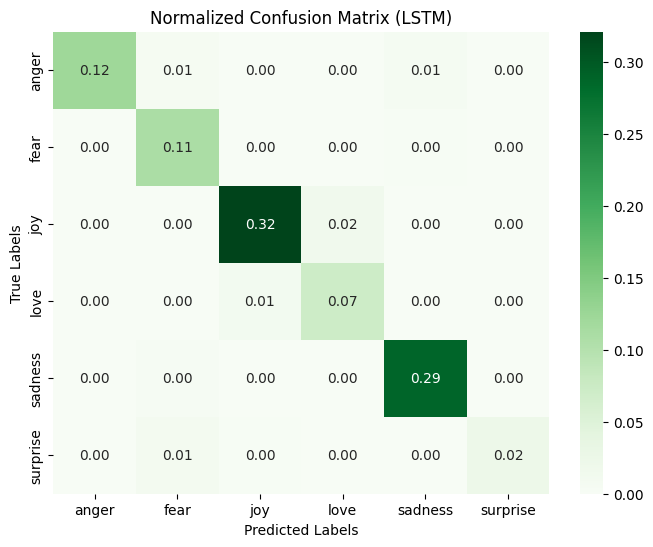

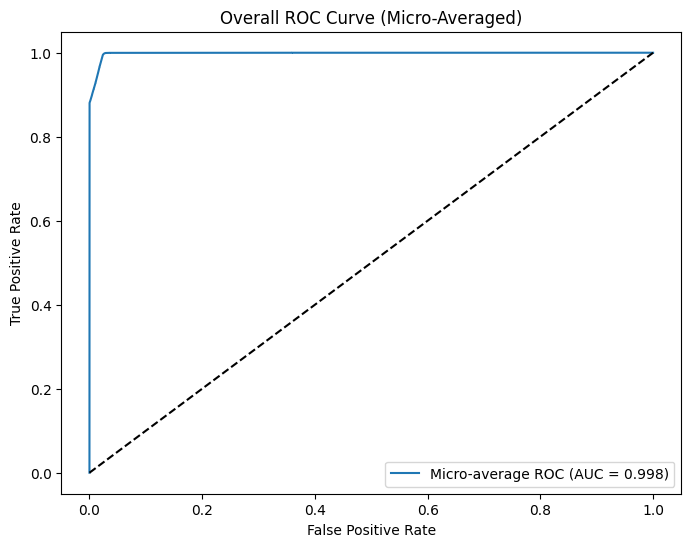

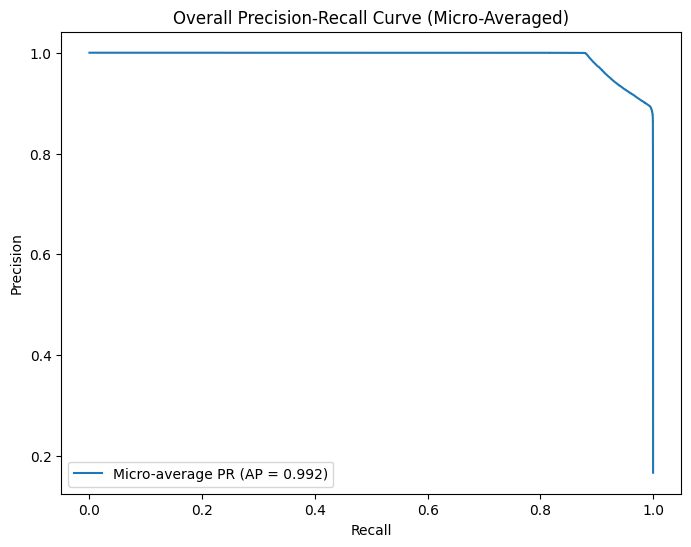

In [15]:
model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        # preds = torch.argmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

        y_prob.extend(probs)
        y_pred.extend(preds)
        y_true.extend(batch_y.numpy())
        # y_pred.extend(preds)
        # y_true.extend(batch_y.numpy())

print(f"Model Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")
print(f"F1 Score (weighted): {f1_score(y_true, y_pred, average='weighted') * 100:.2f}%\n")
print("Classification Report:\n", classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

cm_lstm = pd.DataFrame(
    confusion_matrix(y_true, y_pred, normalize='all'),
    index=['anger','fear','joy','love','sadness','surprise'],
    columns=['anger','fear','joy','love','sadness','surprise']
)

plt.figure(figsize=(8,6))
sns.heatmap(cm_lstm, annot=True, cmap="Greens", fmt=".2f")
plt.title("Normalized Confusion Matrix (LSTM)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# ROC CURVE (Micro-Averaged)
y_true_bin = label_binarize(y_true, classes=list(range(NUM_CLASSES)))
y_prob = np.array(y_prob)

fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"Micro-average ROC (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Overall ROC Curve (Micro-Averaged)")
plt.legend()
plt.show()

# PRECISION–RECALL CURVE (Micro-Averaged)
precision, recall, _ = precision_recall_curve(y_true_bin.ravel(), y_prob.ravel())
avg_precision = average_precision_score(y_true_bin, y_prob, average="micro")

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f"Micro-average PR (AP = {avg_precision:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Overall Precision-Recall Curve (Micro-Averaged)")
plt.legend()
plt.show()

os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "lstm_model_final.pth")
